In [1]:
from importlib import reload  
import numpy as np
import matplotlib.pyplot as plt
import pycraf
import cysgp4
from pycraf import conversions as cnv
from pycraf import protection, antenna, geometry
from astropy import units as u, constants as const
from scepter import skynet,obs
from astropy import coordinates as coord



In [2]:

###reload here
reload(skynet)
reload(obs)

### we're testing with the ie613 lofar station location
longitude = 7.9219 * u.deg
latitude = 53.0950 * u.deg
elevation = 72.0 * u.m
observatory1=cysgp4.PyObserver(longitude.value,latitude.value,elevation.to(u.km).value)
parkes=coord.EarthLocation.of_site('Parkes')
print(parkes.geodetic)
longitude = parkes.geodetic.lon
latitude = parkes.geodetic.lat
elevation = parkes.geodetic.height
observatory2=cysgp4.PyObserver(longitude.value,latitude.value,elevation.to(u.km).value)

GeodeticLocation(lon=<Longitude 148.26351001 deg>, lat=<Latitude -32.9984064 deg>, height=<Quantity 414.75974971 m>)


In [3]:



obsmode='continuum'
ras_df = protection.ra769_limits(mode=obsmode).to_pandas() # 150 MHz RAS band
ras_tab = protection.ra769_limits(mode='continuum')[4] # 0.325 GHz RAS band
# print(ras_df)
print(ras_tab)
# Rx (RAS) parameters
eta_a_rx = 100 * u.percent

frequency bandwidth T_A T_rx T_rms  P_rms_nu   Plim   Plim_nu      Slim        Slim_nu        Efield    Efield_norm 
   MHz       MHz     K   K     mK  dB(W / Hz) dB(W)  dB(W / Hz) dB(W / m2) dB(W / (Hz m2)) dB(uV2 / m2) dB(uV2 / m2)
--------- --------- --- ---- ----- ---------- ------ ---------- ---------- --------------- ------------ ------------
      325         7  40   60 0.870     -259.2 -201.0     -269.2     -189.3          -257.5        -43.5        -51.7


### simulate telescope pointing grid

In [46]:
min_elevation = 0 * u.deg
grid_size = 2. * u.deg
npoints=1 ##pointing per cell
skygrid = skynet.pointgen(niters=npoints,
    step_size=grid_size,
    lat_range=(min_elevation, 90 * u.deg),
    rnd_seed=0,
    )

tel_az, tel_el, grid_info = skygrid 

print(tel_az.shape)


freq = ras_tab['frequency']

p_lim = ras_tab['Plim']
pfd_lim = ras_tab['Slim']
ras_bandwidth = ras_tab['bandwidth']
margin = 0

p_tx_carrier = (-44+margin) * cnv.dBm #CISPR22 maximum emission at 150 MHz is -44 dBm
carrier_bandwidth = ras_tab['bandwidth'] #this is not specified in the french section...
duty_cycle = 100 * u.percent
print(ras_bandwidth)

# freq=10.4*u.GHz


(1, 5156)
6.6 MHz


### set up transmitter class

In [47]:
tx=obs.transmitter_info(p_tx_carrier, carrier_bandwidth, duty_cycle, d_tx=1*u.m,freq=freq)
p_tx=tx.power_tx(ras_bandwidth)
print(p_tx)

-44.0 dB(mW)


In [48]:
gain=tx.satgain1d(30*u.deg)
print(f'1d gain pattern of transmitter at phi = 30 is {gain}')

1d gain pattern of transmitter at phi = 30 is 5.760100803001295 dB


### set up receiver class

In [49]:
dish=100*u.m
eta=0.7 *100*u.percent ## in percentage
### frequency band
## transmitter parameters
sat_antenna=0.1*u.m
### observatory list will be passed on internally like this
observers = np.array([observatory1,observatory2
    ])
rx=obs.receiver_info(dish,eta,observers,freq,bandwidth=ras_bandwidth)

In [50]:
rx.location  ### observatory information is saved here

array([<PyObserver: 7.9219d, 53.0950d, 0.0720km>,
       <PyObserver: 148.2635d, -32.9984d, 0.4148km>], dtype=object)

In [51]:
###load some tle from starlink
import requests
url = 'https://celestrak.org/NORAD/elements/gp.php?GROUP=oneweb&FORMAT=tle'
ctrak_starlink = requests.get(url).text

tle_list = cysgp4.tle_tuples_from_text(ctrak_starlink)

# tle_list

In [52]:
### set time and simulation settings

niters = 1
pydt = cysgp4.PyDateTime() ## take current date and time
start_times_window = 24 * u.hour
time_range, time_resol = 100*u.s, 1*u.s  # seconds
epochiters=time_range/time_resol

# print(start_times,td)
mjds = skynet.plantime(niters,start_times_window,time_range,time_resol,pydt)
print(mjds.shape)

(1, 1, 1, 1, 100, 1)


In [53]:
tles = np.array([
    cysgp4.PyTle(*tle) for tle in tle_list
    ])[:1000]  # use which TLEs

print (f'we are simulating {tles.shape[0]} satellites over {niters*start_times_window.to_value(u.day)} days,')
print(f'each day/epoch contains {epochiters} iterations over with {time_range} seconds')

print(type(tles))

we are simulating 631 satellites over 1.0 days,
each day/epoch contains 100.0 iterations over with 100.0 s seconds
<class 'numpy.ndarray'>


In [54]:
test=obs.obs_sim(tx,rx,tles,skygrid,mjds)


In [55]:
test.populate()



(2, 1, 1, 1, 1, 1) (1, 1, 1, 1, 1, 631) (1, 1, 1, 1, 100, 1)
Obtaining satellite and time information, propagation for large arrays may take a while...
Done. Satellite coordinates obtained


In [56]:
satinfo=test.sat_info

print(test.topo_pos_az.shape)

# g_rx=rx.antgain1d(test.tel_az,test.tel_el,test.topo_pos_az,test.topo_pos_el)


(2, 1, 1, 1, 100, 631)


### calculate beam pointing in satellite reference frame compared to observatory location

In [57]:
ang_sep,delta_az,delta_el,obs_dist=obs.sat_frame_pointing(sat_info=test.sat_info,beam_el=20,beam_az=0)
ang_sep=test.txbeam_angsep(beam_az=20,beam_el=0)

print(ang_sep.shape,obs_dist.shape)

(2, 1, 1, 1, 100, 631) (2, 1, 1, 1, 100, 631)


### calculate gain in observatory direction using 1d antenna pattern

In [58]:
gtx=tx.satgain1d(ang_sep) 


### apply free space path loss over distance

In [59]:
sat_power=tx.fspl(obs_dist*u.km,gtx)

In [60]:
sat_power[0]

<Decibel [[[[[-200.86427613, -197.88310805, -201.15854658, ...,
              -195.64643491, -196.49070002, -200.95448996],
             [-200.86385338, -197.889623  , -201.15809483, ...,
              -195.65975345, -196.47823845, -200.95514164],
             [-200.8634312 , -197.89613408, -201.15764017, ...,
              -195.67306408, -196.46576793, -200.95579203],
             ...,
             [-200.82604944, -198.49240146, -201.1002429 , ...,
              -196.88614435, -195.25745674, -201.01080818],
             [-200.82568621, -198.49840148, -201.0994793 , ...,
              -196.89824133, -195.24470323, -201.01130639],
             [-200.82532364, -198.50439499, -201.09871216, ...,
              -196.91032216, -195.23195418, -201.01180271]]]]] dB(mW)>

### loop all cells

In [61]:
print(f'loop this for all {npoints} pointings')



print('running pointing grid.....')

grx=rx.antgain1d(tp_az=test.tel_az,tp_el=test.tel_el,sat_obs_az=test.topo_pos_az,sat_obs_el=test.topo_pos_el)
readout=obs.prx_cnv(sat_power,grx, outunit=u.W)  ### calculate prx in W
print(readout.shape)

# telescopeindex=0
# dayindex=0
# timeindex=np.arange(0,100,1)
# sourcesum=pfdarray.sum(axis=5) ### sum up all sources
# print(sourcesum.shape)
# timeavg=sourcesum[:,:,:,:,timeindex].mean(axis=4) ### sum up time integration
# print(timeavg.shape)

# timeavg=timeavg.mean(axis=3) ### pick day integration

# print(timeavg.shape)


loop this for all 1 pointings
running pointing grid.....
Obtaining satellite and telescope pointing coordinates, calculation for large arrays may take a while...
Done. putting angular separation into gain pattern function
(2, 1, 5156, 1, 100, 631)


In [62]:
telescopeindex=1
dayindex=0
timeindex=np.arange(0,100,1)

sourcesum=readout.sum(axis=5) ### sum up all sources

print(sourcesum.shape)
timeavg=sourcesum[:,:,:,:,timeindex].mean(axis=4) ### sum up time integration
print(timeavg.shape)

timeavg=timeavg.mean(axis=3) ### pick day integration

print(timeavg.shape)

# print(prxarray)
# pwr_flux_density = (cnv.powerflux_from_prx(totalprx * 1e60, freq, 0 * cnv.dBi) * 1e-60).to(cnv.dB_W_m2)
### this step converts to ra769
# print(pwr_flux_density)

# pfdarray=pwr_flux_density
# prx=cnv.prx_from_powerflux (pwr_flux_density,freq=ras_bandwidth,grx=g_rx)
# print(totalprx.shape)

(2, 1, 5156, 1, 100)
(2, 1, 5156, 1)
(2, 1, 5156)


In [63]:
totalprx=timeavg[telescopeindex]
# totalprx=totalprx.sum(axis=0) ### average over all antennas
print(totalprx.shape)
#### ra769 conversion
_pfds=pwr_flux_density = (cnv.powerflux_from_prx(totalprx * 1e60, freq, 0 * cnv.dBi) * 1e-60).to(cnv.dB_W_m2)
pfd_lin = _pfds.to_value(u.W / u.m ** 2)
pfd_avg = (np.mean(pfd_lin, axis=0) * u.W / u.m ** 2).to(cnv.dB_W_m2)
pfd_98p = (np.percentile(pfd_lin, 98., axis=0) * u.W / u.m ** 2).to(cnv.dB_W_m2)
pfd_max = (np.max(pfd_lin, axis=0) * u.W / u.m ** 2).to(cnv.dB_W_m2)

_pfd_lim_W_m2 = pfd_lim.to_value(u.W / u.m ** 2)

(1, 5156)


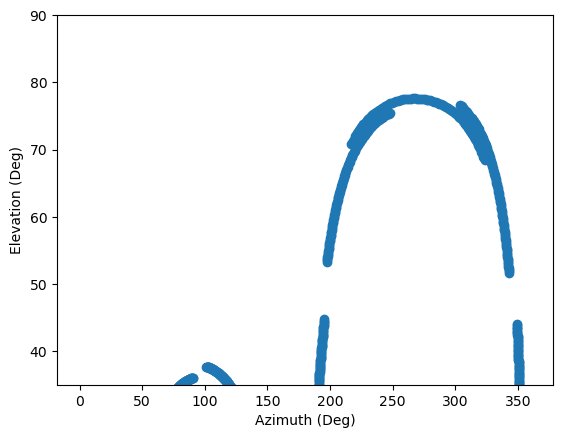

In [64]:
plt.scatter(test.topo_pos_az[telescopeindex,:,0,:,:,:],test.topo_pos_el[telescopeindex,:,0,:,:,:])
plt.ylim(35,90)
plt.xlabel('Azimuth (Deg)')
plt.ylabel('Elevation (Deg)')

plt.show()

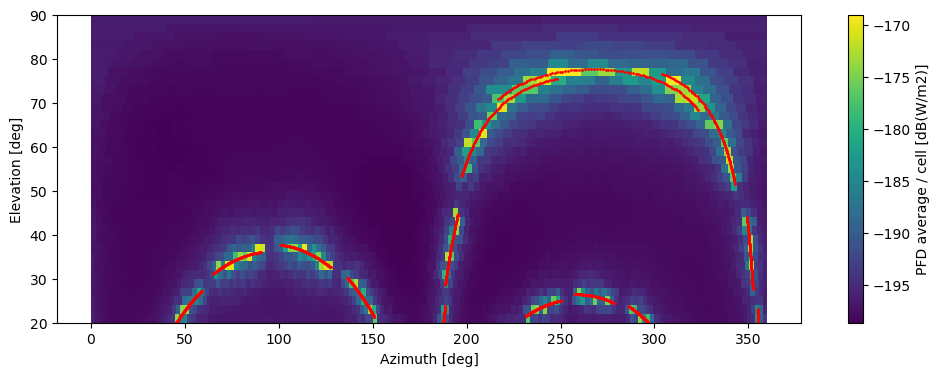

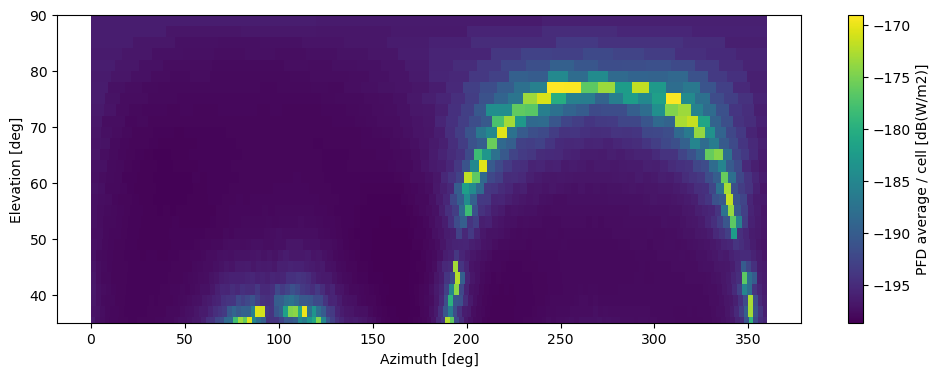

In [65]:
val = pfd_avg.to_value(cnv.dB_W_m2)
### plot with satellites
skynet.plotgrid(val,grid_info,point_az=test.topo_pos_az[telescopeindex,:,0,:,:,:],point_el=test.topo_pos_el[telescopeindex,:,0,:,:,:],
                elmax=90,elmin=20)
### no satellites
skynet.plotgrid(val,grid_info,point_az=[],point_el=[],
                elmax=90,elmin=35)